In [ ]:
from __future__ import print_function
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.manifold import TSNE
import plotly.express as px

# Підготовка даних (1 бал)

Завантажімо дані, змінимо розмір зображень та нормалізуємо їх.

In [ ]:
dataroot = '/content/gdrive/MyDrive/folder'
batch_size = 16
image_size = 128

In [ ]:
dataset = datasets.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
device = torch.device("cuda:0")

# Побудова та навчання моделі (2 бали)

Ініціалізуємо функцію ваг.

In [ ]:
def weights_init(module):
    if isinstance(module, nn.Conv2d):
        nn.init.normal_(module.weight.data, mean=0.0, std=0.02)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.normal_(module.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(module.bias.data, 0)

In [ ]:
latent_size = 100

Створюємо клас для генератора. Генератор приймає на вхід тензор розміру latent_size (обрано 100) x 1 x 1, та генерує зображення розміру 3 x image_size x image_size.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 64 * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

Ініціалізуємо генератор та переносимо його на гпу. Ініціалізуємо ваги.

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

Створюємо клас для діскрімінатора. Приймає тензор розміру 3 на image_size на image_size, повертає ймовірність належності до справжнього/несправжнього зображення.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32 * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32 * 2, 32 * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32 * 4, 32 * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32 * 8, 32 * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32 * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32 * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

Так само ініціалізуємо діскрімінатор та ваги для нього, переносимо на гпу.

In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, mom

Задаємо learning rate, кількість епох, критерій, оптимізатор.
Ініціалізуємо fixed_noise, який є це тензором шуму, який використовується як фіксований вхід для генератора зображень. Це допомагає оцінити вплив генератора на зображення, не змінюючи шум при кожній ітерації. Крім того, визначено для оптимізатор параметр betas. За замовчуванням він дорівнює (1, 0.999). В ході експерименту було визначено, що при (0.5, 0.999) код працює краще.

In [ ]:
lr = 0.0001
num_epochs = 50
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

Функція для тренування. На кожній десятій епосі зберігаємо генератор та дискримінатор для подальшої роботи.

In [ ]:
img_list = []
gen_losses = []
dis_losses = []
iters = 0

for epoch in range(num_epochs):
    if epoch%10==0:
        torch.save(generator.state_dict(), '/content/gdrive/MyDrive/my_model{}.pth'.format(epoch))
        torch.save(discriminator.state_dict(), '/content/gdrive/MyDrive/my_model{}.pth'.format(epoch))
    for i, data in enumerate(dataloader, 0):
        discriminator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizer_disc.step()

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizer_gen.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))

            gen_losses.append(errG.item())
            dis_losses.append(errD.item())

        iters += 1

[0/50][0/197]	Loss_D: 0.7186	Loss_G: 2.5080
[0/50][100/197]	Loss_D: 0.9525	Loss_G: 2.1893
[1/50][0/197]	Loss_D: 0.6898	Loss_G: 2.2021
[1/50][100/197]	Loss_D: 0.7482	Loss_G: 2.4737
[2/50][0/197]	Loss_D: 0.4799	Loss_G: 2.4656
[2/50][100/197]	Loss_D: 0.6706	Loss_G: 3.7362
[3/50][0/197]	Loss_D: 0.4872	Loss_G: 3.5783
[3/50][100/197]	Loss_D: 0.7463	Loss_G: 1.3852
[4/50][0/197]	Loss_D: 0.7841	Loss_G: 4.1755
[4/50][100/197]	Loss_D: 0.4556	Loss_G: 2.67485
[5/50][0/197]	Loss_D: 0.6688	Loss_G: 3.7730
[5/50][100/197]	Loss_D: 0.4236	Loss_G: 2.8403
[6/50][0/197]	Loss_D: 0.5250	Loss_G: 4.5318
[6/50][100/197]	Loss_D: 0.8953	Loss_G: 3.1556
[7/50][0/197]	Loss_D: 0.4328	Loss_G: 4.7114
[7/50][100/197]	Loss_D: 0.3711	Loss_G: 4.3506
[8/50][0/197]	Loss_D: 0.3623	Loss_G: 3.30009
[8/50][100/197]	Loss_D: 0.2491	Loss_G: 3.9276
[9/50][0/197]	Loss_D: 0.4027	Loss_G: 3.9915
[9/50][100/197]	Loss_D: 0.3944	Loss_G: 3.5467
[10/50][0/197]	Loss_D: 0.7292	Loss_G: 5.0667
[10/50][100/197]	Loss_D: 0.4379	Loss_G: 2.2665
[11/50

In [ ]:
torch.save(generator.state_dict(), '/content/gdrive/MyDrive/my_model.pth')
torch.save(discriminator.state_dict(), '/content/gdrive/MyDrive/my_model.pth')

Побудуємо функції для втрат. Так якзберігались втрати не лише на кожній епосі, а й для середини епох, можна побачити деякі викиди. В цілому втрати дискримінатора менші, ніж генератора, що є нормальним перебігом речей.

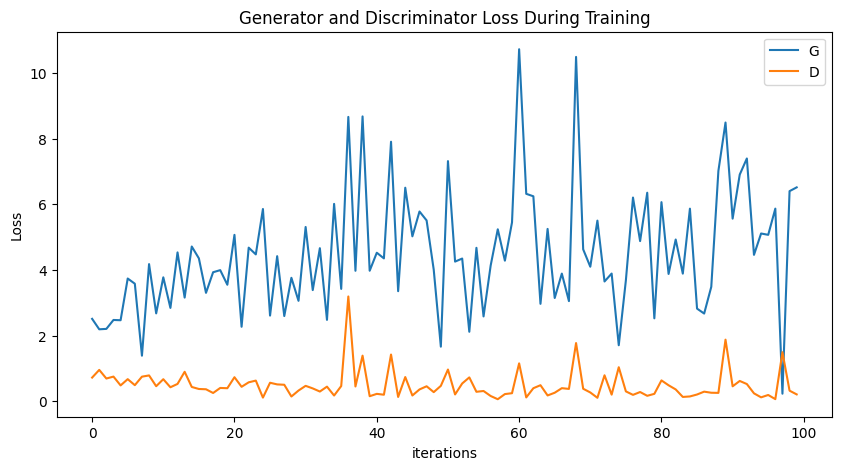

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(dis_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Генерація зображень (1 б)

**Що можна сказати про якість зображень?**

Якість згенерованих даних достатьно далека від ідеалу, хоча якщо відійти подалі та зняти окуляри, можна навіть подумати, що фото реальні. В цілому присутні всі риси людського обличчя, згенеровані зображення представляють людей різного віку, статі, кольору шкіри. Для невеликої кількості зображень для навчання - результат чудовий.

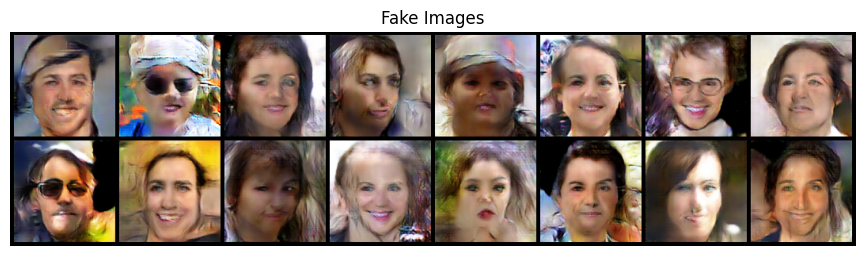

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(generator(torch.randn(16, latent_size, 1, 1, device=device))[:64], padding=5, normalize=True).cpu(),(1, 2, 0)))

plt.show()

# Leave-one-out-1-NN classifier accuracy (6 балів)

In [ ]:
import torch
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

In [ ]:
n_fake_images = 500
fake_images = (vutils.make_grid(generator(torch.randn(16, latent_size, 1, 1, device=device))[:64], padding=5, normalize=True).cpu(),(1, 2, 0))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=1)
X = []
y = []
count = 0
for real_images, labels in dataloader:
    X.extend(real_images.view(real_images.size(0), -1).numpy())
    y.extend(labels.numpy())
    count += len(real_images)
    if count >= 500:
        break
for i in range(n_fake_images):
    fake_batch = generator(torch.randn(16, latent_size, 1, 1, device=device))
    fake_images = fake_batch.detach().view(fake_batch.size(0), -1).cpu().numpy()
    X.extend(fake_images)
    y.extend([1] * 16)
accuracies = []
for i in range(len(X)):
    X_train = X[:i] + X[i+1:]
    y_train = y[:i] + y[i+1:]
    X_test = [X[i]]
    y_test = [y[i]]
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

In [ ]:
mean_accuracy = sum(accuracies) / len(accuracies)
print("Середня точність leave-one-out оцінки:", mean_accuracy)

Середня точність leave-one-out оцінки: 0.8580134064594759


**Що можна сказати про результат? Яку б точність ми хотіли б отримати?**

По-перше, зазначу, що сам класифікатор працював у мене 3 години і був аварійно завершений через брак ресурсів, втім середню точність ми все ж отримали.
По-друге, стосовно питання: результат достатньо посередній. Ми хочемо отримати точність 0.5 - це ідеал, або хоча б близьку. Це означало б, що класифікатору складно відрізнити справжні зображення від згенерованих і він робить це навмання.

# Візуалізація розподілення (2 б)

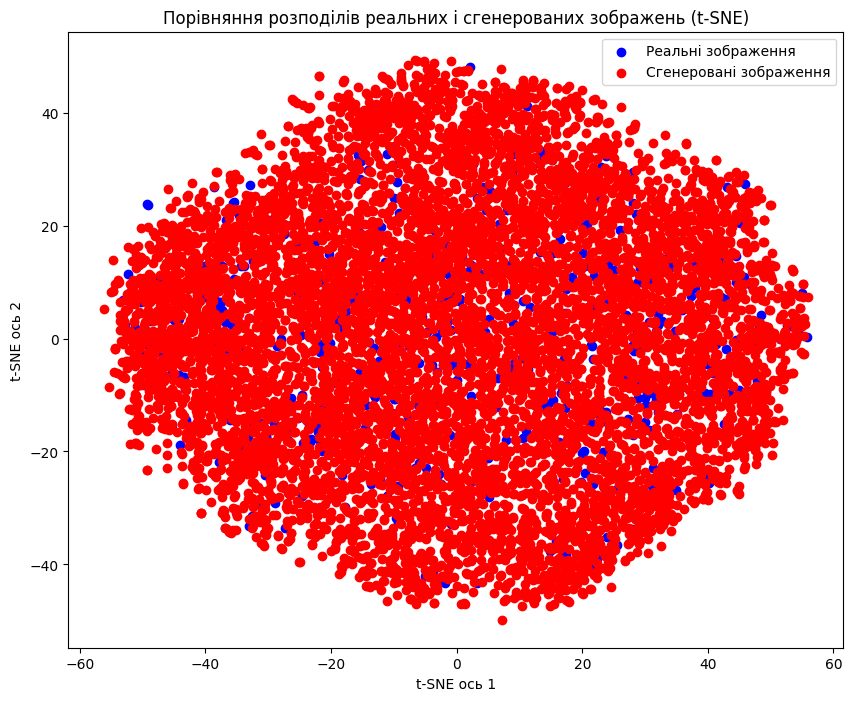

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_real = []
X_fake = []
count = 0
for real_images, _ in dataloader:
    X_real.extend(real_images.view(real_images.size(0), -1).numpy())
    count += len(real_images)
    if count >= 500:
        break
for i in range(n_fake_images):
    fake_batch = generator(torch.randn(16, latent_size, 1, 1, device=device))
    fake_images = fake_batch.detach().view(fake_batch.size(0), -1).cpu().numpy()
    X_fake.extend(fake_images)
X_real = np.array(X_real)
X_fake = np.array(X_fake)
X_combined = np.concatenate((X_real, X_fake), axis=0)
y_combined = np.array([0] * len(X_real) + [1] * len(X_fake))
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined)
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[y_combined == 0, 0], X_tsne[y_combined == 0, 1], c='b', label='Реальні зображення')
plt.scatter(X_tsne[y_combined == 1, 0], X_tsne[y_combined == 1, 1], c='r', label='Сгенеровані зображення')
plt.title('Порівняння розподілів реальних і сгенерованих зображень (t-SNE)')
plt.xlabel('t-SNE ось 1')
plt.ylabel('t-SNE ось 2')
plt.legend()
plt.show()


Чіткого розподілення на два класи ми не бачимо, точки між собою перемішані, що є хорошим. Це означає, що реальні зображення достатньо близькі до згенерованих.